In [1]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [3]:
dataset = 'GTZAN'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

1000 features extracted


In [4]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=1/10) # NO TOCAR!
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=1/9)        # NO TOCAR!

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

800 training samples
100 validation samples
100 test samples


In [5]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=0.25)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [6]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{str((i+1)*len(data)).zfill((len(str(len_glob_data))))}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [7]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [8]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [9]:
# Hyperparameters

input_size = 25
hidden_size = [256, 128, 64, 32]
num_classes = 10

train_batch_size = 5 # NO TOCAR!
valid_batch_size = 100

num_epochs = 600
learning_rate = 0.0001

In [10]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = DNNClassifier(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(50, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [250/800 (31%)]	Loss: 2.373281
Train Epoch: 1 [500/800 (62%)]	Loss: 2.375836
Train Epoch: 1 [750/800 (93%)]	Loss: 2.294637

Validation set: Average loss: 2.2745, Accuracy: 12/100 (12%)

Train Epoch: 2 [250/800 (31%)]	Loss: 2.23406
Train Epoch: 2 [500/800 (62%)]	Loss: 2.37006
Train Epoch: 2 [750/800 (93%)]	Loss: 2.251255

Validation set: Average loss: 2.246, Accuracy: 14/100 (14%)

Train Epoch: 3 [250/800 (31%)]	Loss: 2.228754
Train Epoch: 3 [500/800 (62%)]	Loss: 2.274059
Train Epoch: 3 [750/800 (93%)]	Loss: 2.349709

Validation set: Average loss: 2.222, Accuracy: 16/100 (16%)

Train Epoch: 4 [250/800 (31%)]	Loss: 2.151067
Train Epoch: 4 [500/800 (62%)]	Loss: 2.293241
Train Epoch: 4 [750/800 (93%)]	Loss: 2.392759

Validation set: Average loss: 2.1868, Accuracy: 25/100 (25%)

Train Epoch: 5 [250/800 (31%)]	Loss: 2.175117
Train Epoch: 5 [500/800 (62%)]	Loss: 2.282613
Train Epoch: 5 [750/800 (93%)]	Loss: 2.323553

Validation set: Average loss: 2.145, Accuracy: 24/100 (24%)



Train Epoch: 41 [750/800 (93%)]	Loss: 1.926741

Validation set: Average loss: 1.5061, Accuracy: 51/100 (51%)

Train Epoch: 42 [250/800 (31%)]	Loss: 1.259795
Train Epoch: 42 [500/800 (62%)]	Loss: 1.484592
Train Epoch: 42 [750/800 (93%)]	Loss: 1.606856

Validation set: Average loss: 1.4665, Accuracy: 54/100 (54%)

Train Epoch: 43 [250/800 (31%)]	Loss: 1.301771
Train Epoch: 43 [500/800 (62%)]	Loss: 1.376213
Train Epoch: 43 [750/800 (93%)]	Loss: 1.893007

Validation set: Average loss: 1.4741, Accuracy: 50/100 (50%)

Train Epoch: 44 [250/800 (31%)]	Loss: 1.183994
Train Epoch: 44 [500/800 (62%)]	Loss: 1.452572
Train Epoch: 44 [750/800 (93%)]	Loss: 1.599128

Validation set: Average loss: 1.4591, Accuracy: 54/100 (54%)

Train Epoch: 45 [250/800 (31%)]	Loss: 1.088683
Train Epoch: 45 [500/800 (62%)]	Loss: 1.482796
Train Epoch: 45 [750/800 (93%)]	Loss: 1.641282

Validation set: Average loss: 1.4416, Accuracy: 50/100 (50%)

Train Epoch: 46 [250/800 (31%)]	Loss: 1.168195
Train Epoch: 46 [500/800 (6

Train Epoch: 82 [250/800 (31%)]	Loss: 0.863308
Train Epoch: 82 [500/800 (62%)]	Loss: 0.897465
Train Epoch: 82 [750/800 (93%)]	Loss: 1.166735

Validation set: Average loss: 1.2615, Accuracy: 54/100 (54%)

Train Epoch: 83 [250/800 (31%)]	Loss: 0.561672
Train Epoch: 83 [500/800 (62%)]	Loss: 0.811614
Train Epoch: 83 [750/800 (93%)]	Loss: 1.208444

Validation set: Average loss: 1.2508, Accuracy: 56/100 (56%)

Train Epoch: 84 [250/800 (31%)]	Loss: 0.559753
Train Epoch: 84 [500/800 (62%)]	Loss: 0.907798
Train Epoch: 84 [750/800 (93%)]	Loss: 1.063393

Validation set: Average loss: 1.2545, Accuracy: 52/100 (52%)

Train Epoch: 85 [250/800 (31%)]	Loss: 0.762323
Train Epoch: 85 [500/800 (62%)]	Loss: 1.502397
Train Epoch: 85 [750/800 (93%)]	Loss: 1.062536

Validation set: Average loss: 1.2879, Accuracy: 53/100 (53%)

Train Epoch: 86 [250/800 (31%)]	Loss: 0.660083
Train Epoch: 86 [500/800 (62%)]	Loss: 0.697548
Train Epoch: 86 [750/800 (93%)]	Loss: 0.991625

Validation set: Average loss: 1.2685, Accu

Train Epoch: 122 [250/800 (31%)]	Loss: 0.663162
Train Epoch: 122 [500/800 (62%)]	Loss: 0.558403
Train Epoch: 122 [750/800 (93%)]	Loss: 0.861071

Validation set: Average loss: 1.2256, Accuracy: 53/100 (53%)

Train Epoch: 123 [250/800 (31%)]	Loss: 0.80631
Train Epoch: 123 [500/800 (62%)]	Loss: 0.700146
Train Epoch: 123 [750/800 (93%)]	Loss: 0.744343

Validation set: Average loss: 1.2142, Accuracy: 54/100 (54%)

Train Epoch: 124 [250/800 (31%)]	Loss: 0.438711
Train Epoch: 124 [500/800 (62%)]	Loss: 0.353973
Train Epoch: 124 [750/800 (93%)]	Loss: 0.784062

Validation set: Average loss: 1.224, Accuracy: 54/100 (54%)

Train Epoch: 125 [250/800 (31%)]	Loss: 0.39701
Train Epoch: 125 [500/800 (62%)]	Loss: 0.587538
Train Epoch: 125 [750/800 (93%)]	Loss: 0.928516

Validation set: Average loss: 1.1828, Accuracy: 53/100 (53%)

Train Epoch: 126 [250/800 (31%)]	Loss: 0.810726
Train Epoch: 126 [500/800 (62%)]	Loss: 0.399535
Train Epoch: 126 [750/800 (93%)]	Loss: 0.826949

Validation set: Average loss: 

Train Epoch: 162 [250/800 (31%)]	Loss: 0.262577
Train Epoch: 162 [500/800 (62%)]	Loss: 0.924694
Train Epoch: 162 [750/800 (93%)]	Loss: 1.330389

Validation set: Average loss: 1.2361, Accuracy: 50/100 (50%)

Train Epoch: 163 [250/800 (31%)]	Loss: 0.380776
Train Epoch: 163 [500/800 (62%)]	Loss: 0.16002
Train Epoch: 163 [750/800 (93%)]	Loss: 1.363163

Validation set: Average loss: 1.2351, Accuracy: 53/100 (53%)

Train Epoch: 164 [250/800 (31%)]	Loss: 0.663986
Train Epoch: 164 [500/800 (62%)]	Loss: 1.073605
Train Epoch: 164 [750/800 (93%)]	Loss: 0.763884

Validation set: Average loss: 1.2233, Accuracy: 57/100 (57%)

Train Epoch: 165 [250/800 (31%)]	Loss: 0.314508
Train Epoch: 165 [500/800 (62%)]	Loss: 0.119262
Train Epoch: 165 [750/800 (93%)]	Loss: 0.563464

Validation set: Average loss: 1.2057, Accuracy: 56/100 (56%)

Train Epoch: 166 [250/800 (31%)]	Loss: 0.266445
Train Epoch: 166 [500/800 (62%)]	Loss: 0.212253
Train Epoch: 166 [750/800 (93%)]	Loss: 0.899081

Validation set: Average loss

Train Epoch: 202 [250/800 (31%)]	Loss: 0.234351
Train Epoch: 202 [500/800 (62%)]	Loss: 0.391395
Train Epoch: 202 [750/800 (93%)]	Loss: 0.473806

Validation set: Average loss: 1.2756, Accuracy: 56/100 (56%)

Train Epoch: 203 [250/800 (31%)]	Loss: 0.177177
Train Epoch: 203 [500/800 (62%)]	Loss: 0.628806
Train Epoch: 203 [750/800 (93%)]	Loss: 0.397044

Validation set: Average loss: 1.3088, Accuracy: 55/100 (55%)

Train Epoch: 204 [250/800 (31%)]	Loss: 0.243219
Train Epoch: 204 [500/800 (62%)]	Loss: 0.311843
Train Epoch: 204 [750/800 (93%)]	Loss: 0.486081

Validation set: Average loss: 1.3122, Accuracy: 55/100 (55%)

Train Epoch: 205 [250/800 (31%)]	Loss: 0.334374
Train Epoch: 205 [500/800 (62%)]	Loss: 0.179819
Train Epoch: 205 [750/800 (93%)]	Loss: 0.350699

Validation set: Average loss: 1.3031, Accuracy: 57/100 (57%)

Train Epoch: 206 [250/800 (31%)]	Loss: 0.236436
Train Epoch: 206 [500/800 (62%)]	Loss: 0.178216
Train Epoch: 206 [750/800 (93%)]	Loss: 1.291288

Validation set: Average los

Train Epoch: 242 [250/800 (31%)]	Loss: 0.134366
Train Epoch: 242 [500/800 (62%)]	Loss: 0.372354
Train Epoch: 242 [750/800 (93%)]	Loss: 0.232009

Validation set: Average loss: 1.3178, Accuracy: 55/100 (55%)

Train Epoch: 243 [250/800 (31%)]	Loss: 0.141383
Train Epoch: 243 [500/800 (62%)]	Loss: 0.088554
Train Epoch: 243 [750/800 (93%)]	Loss: 0.487337

Validation set: Average loss: 1.3175, Accuracy: 54/100 (54%)

Train Epoch: 244 [250/800 (31%)]	Loss: 0.126969
Train Epoch: 244 [500/800 (62%)]	Loss: 0.330526
Train Epoch: 244 [750/800 (93%)]	Loss: 0.507127

Validation set: Average loss: 1.3128, Accuracy: 56/100 (56%)

Train Epoch: 245 [250/800 (31%)]	Loss: 1.160556
Train Epoch: 245 [500/800 (62%)]	Loss: 0.830857
Train Epoch: 245 [750/800 (93%)]	Loss: 0.246658

Validation set: Average loss: 1.3484, Accuracy: 59/100 (59%)

Train Epoch: 246 [250/800 (31%)]	Loss: 0.401964
Train Epoch: 246 [500/800 (62%)]	Loss: 0.568386
Train Epoch: 246 [750/800 (93%)]	Loss: 0.746633

Validation set: Average los

Train Epoch: 282 [250/800 (31%)]	Loss: 0.390532
Train Epoch: 282 [500/800 (62%)]	Loss: 0.264609
Train Epoch: 282 [750/800 (93%)]	Loss: 0.37155

Validation set: Average loss: 1.3511, Accuracy: 55/100 (55%)

Train Epoch: 283 [250/800 (31%)]	Loss: 0.053952
Train Epoch: 283 [500/800 (62%)]	Loss: 0.461201
Train Epoch: 283 [750/800 (93%)]	Loss: 0.373207

Validation set: Average loss: 1.373, Accuracy: 55/100 (55%)

Train Epoch: 284 [250/800 (31%)]	Loss: 0.851108
Train Epoch: 284 [500/800 (62%)]	Loss: 0.096604
Train Epoch: 284 [750/800 (93%)]	Loss: 0.299253

Validation set: Average loss: 1.3834, Accuracy: 55/100 (55%)

Train Epoch: 285 [250/800 (31%)]	Loss: 0.092166
Train Epoch: 285 [500/800 (62%)]	Loss: 0.385906
Train Epoch: 285 [750/800 (93%)]	Loss: 0.225521

Validation set: Average loss: 1.3519, Accuracy: 56/100 (56%)

Train Epoch: 286 [250/800 (31%)]	Loss: 0.159295
Train Epoch: 286 [500/800 (62%)]	Loss: 0.234014
Train Epoch: 286 [750/800 (93%)]	Loss: 0.079407

Validation set: Average loss:

Train Epoch: 322 [250/800 (31%)]	Loss: 0.152967
Train Epoch: 322 [500/800 (62%)]	Loss: 0.075815
Train Epoch: 322 [750/800 (93%)]	Loss: 0.180208

Validation set: Average loss: 1.391, Accuracy: 56/100 (56%)

Train Epoch: 323 [250/800 (31%)]	Loss: 0.047469
Train Epoch: 323 [500/800 (62%)]	Loss: 0.144201
Train Epoch: 323 [750/800 (93%)]	Loss: 0.121315

Validation set: Average loss: 1.3376, Accuracy: 57/100 (57%)

Train Epoch: 324 [250/800 (31%)]	Loss: 0.3189
Train Epoch: 324 [500/800 (62%)]	Loss: 0.080583
Train Epoch: 324 [750/800 (93%)]	Loss: 0.105444

Validation set: Average loss: 1.4251, Accuracy: 55/100 (55%)

Train Epoch: 325 [250/800 (31%)]	Loss: 0.055579
Train Epoch: 325 [500/800 (62%)]	Loss: 0.159806
Train Epoch: 325 [750/800 (93%)]	Loss: 0.973711

Validation set: Average loss: 1.4519, Accuracy: 55/100 (55%)

Train Epoch: 326 [250/800 (31%)]	Loss: 0.12135
Train Epoch: 326 [500/800 (62%)]	Loss: 0.520891
Train Epoch: 326 [750/800 (93%)]	Loss: 0.130709

Validation set: Average loss: 1

Train Epoch: 362 [250/800 (31%)]	Loss: 0.103379
Train Epoch: 362 [500/800 (62%)]	Loss: 0.125897
Train Epoch: 362 [750/800 (93%)]	Loss: 0.189365

Validation set: Average loss: 1.5004, Accuracy: 57/100 (57%)

Train Epoch: 363 [250/800 (31%)]	Loss: 0.093129
Train Epoch: 363 [500/800 (62%)]	Loss: 0.04008
Train Epoch: 363 [750/800 (93%)]	Loss: 0.131075

Validation set: Average loss: 1.5154, Accuracy: 54/100 (54%)

Train Epoch: 364 [250/800 (31%)]	Loss: 0.042472
Train Epoch: 364 [500/800 (62%)]	Loss: 0.08349
Train Epoch: 364 [750/800 (93%)]	Loss: 0.273191

Validation set: Average loss: 1.4145, Accuracy: 57/100 (57%)

Train Epoch: 365 [250/800 (31%)]	Loss: 0.078112
Train Epoch: 365 [500/800 (62%)]	Loss: 0.554506
Train Epoch: 365 [750/800 (93%)]	Loss: 0.180555

Validation set: Average loss: 1.4523, Accuracy: 57/100 (57%)

Train Epoch: 366 [250/800 (31%)]	Loss: 0.207434
Train Epoch: 366 [500/800 (62%)]	Loss: 0.042564
Train Epoch: 366 [750/800 (93%)]	Loss: 0.427251

Validation set: Average loss:

Train Epoch: 402 [250/800 (31%)]	Loss: 0.14178
Train Epoch: 402 [500/800 (62%)]	Loss: 0.119708
Train Epoch: 402 [750/800 (93%)]	Loss: 0.264119

Validation set: Average loss: 1.5136, Accuracy: 55/100 (55%)

Train Epoch: 403 [250/800 (31%)]	Loss: 0.440661
Train Epoch: 403 [500/800 (62%)]	Loss: 0.555861
Train Epoch: 403 [750/800 (93%)]	Loss: 0.308095

Validation set: Average loss: 1.5291, Accuracy: 59/100 (59%)

Train Epoch: 404 [250/800 (31%)]	Loss: 0.133978
Train Epoch: 404 [500/800 (62%)]	Loss: 0.021304
Train Epoch: 404 [750/800 (93%)]	Loss: 0.433481

Validation set: Average loss: 1.5362, Accuracy: 56/100 (56%)

Train Epoch: 405 [250/800 (31%)]	Loss: 0.070339
Train Epoch: 405 [500/800 (62%)]	Loss: 0.02483
Train Epoch: 405 [750/800 (93%)]	Loss: 0.04729

Validation set: Average loss: 1.4462, Accuracy: 57/100 (57%)

Train Epoch: 406 [250/800 (31%)]	Loss: 0.154232
Train Epoch: 406 [500/800 (62%)]	Loss: 0.030611
Train Epoch: 406 [750/800 (93%)]	Loss: 0.029586

Validation set: Average loss: 

Train Epoch: 442 [250/800 (31%)]	Loss: 0.072817
Train Epoch: 442 [500/800 (62%)]	Loss: 0.071989
Train Epoch: 442 [750/800 (93%)]	Loss: 0.152972

Validation set: Average loss: 1.5457, Accuracy: 58/100 (58%)

Train Epoch: 443 [250/800 (31%)]	Loss: 0.019851
Train Epoch: 443 [500/800 (62%)]	Loss: 0.085705
Train Epoch: 443 [750/800 (93%)]	Loss: 0.06561

Validation set: Average loss: 1.4661, Accuracy: 59/100 (59%)

Train Epoch: 444 [250/800 (31%)]	Loss: 0.109587
Train Epoch: 444 [500/800 (62%)]	Loss: 0.03531
Train Epoch: 444 [750/800 (93%)]	Loss: 0.114694

Validation set: Average loss: 1.4598, Accuracy: 62/100 (62%)

Train Epoch: 445 [250/800 (31%)]	Loss: 0.12671
Train Epoch: 445 [500/800 (62%)]	Loss: 0.479162
Train Epoch: 445 [750/800 (93%)]	Loss: 0.11724

Validation set: Average loss: 1.4996, Accuracy: 59/100 (59%)

Train Epoch: 446 [250/800 (31%)]	Loss: 0.021448
Train Epoch: 446 [500/800 (62%)]	Loss: 0.206516
Train Epoch: 446 [750/800 (93%)]	Loss: 0.0905

Validation set: Average loss: 1.4

Train Epoch: 482 [250/800 (31%)]	Loss: 0.030018
Train Epoch: 482 [500/800 (62%)]	Loss: 0.01357
Train Epoch: 482 [750/800 (93%)]	Loss: 0.032005

Validation set: Average loss: 1.6686, Accuracy: 55/100 (55%)

Train Epoch: 483 [250/800 (31%)]	Loss: 0.01129
Train Epoch: 483 [500/800 (62%)]	Loss: 0.583549
Train Epoch: 483 [750/800 (93%)]	Loss: 0.03947

Validation set: Average loss: 1.6632, Accuracy: 57/100 (57%)

Train Epoch: 484 [250/800 (31%)]	Loss: 0.014862
Train Epoch: 484 [500/800 (62%)]	Loss: 0.154253
Train Epoch: 484 [750/800 (93%)]	Loss: 0.097386

Validation set: Average loss: 1.6961, Accuracy: 54/100 (54%)

Train Epoch: 485 [250/800 (31%)]	Loss: 0.033459
Train Epoch: 485 [500/800 (62%)]	Loss: 0.007888
Train Epoch: 485 [750/800 (93%)]	Loss: 0.164223

Validation set: Average loss: 1.66, Accuracy: 54/100 (54%)

Train Epoch: 486 [250/800 (31%)]	Loss: 0.060897
Train Epoch: 486 [500/800 (62%)]	Loss: 0.232654
Train Epoch: 486 [750/800 (93%)]	Loss: 0.522623

Validation set: Average loss: 1.

Train Epoch: 522 [250/800 (31%)]	Loss: 0.157759
Train Epoch: 522 [500/800 (62%)]	Loss: 0.010744
Train Epoch: 522 [750/800 (93%)]	Loss: 0.088698

Validation set: Average loss: 1.586, Accuracy: 58/100 (58%)

Train Epoch: 523 [250/800 (31%)]	Loss: 0.021232
Train Epoch: 523 [500/800 (62%)]	Loss: 0.011155
Train Epoch: 523 [750/800 (93%)]	Loss: 0.267742

Validation set: Average loss: 1.6089, Accuracy: 58/100 (58%)

Train Epoch: 524 [250/800 (31%)]	Loss: 0.03439
Train Epoch: 524 [500/800 (62%)]	Loss: 0.079568
Train Epoch: 524 [750/800 (93%)]	Loss: 0.095496

Validation set: Average loss: 1.6636, Accuracy: 56/100 (56%)

Train Epoch: 525 [250/800 (31%)]	Loss: 0.012986
Train Epoch: 525 [500/800 (62%)]	Loss: 0.125047
Train Epoch: 525 [750/800 (93%)]	Loss: 0.07686

Validation set: Average loss: 1.6169, Accuracy: 56/100 (56%)

Train Epoch: 526 [250/800 (31%)]	Loss: 0.337823
Train Epoch: 526 [500/800 (62%)]	Loss: 0.002494
Train Epoch: 526 [750/800 (93%)]	Loss: 0.030592

Validation set: Average loss: 

Train Epoch: 562 [250/800 (31%)]	Loss: 0.096581
Train Epoch: 562 [500/800 (62%)]	Loss: 0.0516
Train Epoch: 562 [750/800 (93%)]	Loss: 0.677987

Validation set: Average loss: 1.6945, Accuracy: 53/100 (53%)

Train Epoch: 563 [250/800 (31%)]	Loss: 0.047337
Train Epoch: 563 [500/800 (62%)]	Loss: 0.196216
Train Epoch: 563 [750/800 (93%)]	Loss: 0.009917

Validation set: Average loss: 1.5988, Accuracy: 56/100 (56%)

Train Epoch: 564 [250/800 (31%)]	Loss: 0.014137
Train Epoch: 564 [500/800 (62%)]	Loss: 0.028149
Train Epoch: 564 [750/800 (93%)]	Loss: 0.030855

Validation set: Average loss: 1.5622, Accuracy: 56/100 (56%)

Train Epoch: 565 [250/800 (31%)]	Loss: 0.018382
Train Epoch: 565 [500/800 (62%)]	Loss: 0.12459
Train Epoch: 565 [750/800 (93%)]	Loss: 0.145659

Validation set: Average loss: 1.6492, Accuracy: 56/100 (56%)

Train Epoch: 566 [250/800 (31%)]	Loss: 0.283131
Train Epoch: 566 [500/800 (62%)]	Loss: 0.004541
Train Epoch: 566 [750/800 (93%)]	Loss: 0.067367

Validation set: Average loss: 

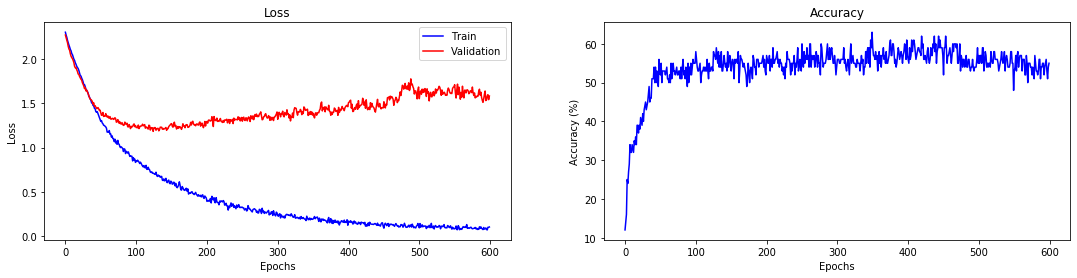

In [11]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()

In [12]:
test_data_batches = data_batcher(test_data, valid_batch_size)
accuracy = test(model, device, test_data_batches)

Test set: Accuracy: 67/100 (67%)

